# Contribution score analysis

This notebook generates plots related to the CNN contribution scores.

Scores were calculated first using the `run_interpretation_in_avg_model.py` and saved to `contributions_ensemble_cnn_model.pickle`.

In [1]:
import json
import os
import pickle
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pandas
import seaborn

utils_dir = '../utils'
sys.path.append(utils_dir)
import seq_utils
import cnn_vgg
import custom_plots

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
# Relevant column names
tpm_fraction_list = ['input', '80S', 'LMW', 'HMW']
pol_fraction_list = ['80S', 'LMW', 'HMW']
timepoint_list = [2, 4, 6, 10]

min_input_tpm_col = 'min_TPM_input'

# Input TPM columns
input_tpm_cols = [f'gmean_TPM_input_{t}hpf' for t in timepoint_list]
input_log2_tpm_cols = [f'log2_TPM_input_{t}hpf' for t in timepoint_list]
diff_log2_tpm_input_cols = [f'diff_log2_TPM_input_{t}-2hpf' for t in timepoint_list[1:]]

# MRL columns
mrl_cols = [f'MRL_{t}hpf' for t in timepoint_list]
log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]

# Model outputs
model_outputs = log2_mrl_cols + diff_log2_tpm_input_cols

# Length model residuals
res_cols = [f'res_{c}' for c in model_outputs]

# Predictions
pred_len_cols = [f'pred_len_{c}' for c in model_outputs]
pred_cnn_cols = [f'pred_cnn_ens_{c}' for c in model_outputs]
pred_full_cols = [f'pred_full_{c}' for c in model_outputs]

In [4]:
# Code to make an extended set of model outputs, containing the
# differences in MRL and input TPM between timepoints
def make_extended_shap(val):
    val_extended = numpy.array([
            val[0],
            val[1],
            val[2],
            val[3],
            val[1] - val[0],
            val[2] - val[0],
            val[3] - val[0],
            val[2] - val[1],
            val[3] - val[1],
            val[3] - val[2],
            val[4],
            val[5],
            val[6],
            val[5] - val[ 4],
            val[6] - val[4],
            val[6] - val[5],
        ])
    return val_extended

model_outputs_ext_labels = [
    'log2_MRL_2hpf',
    'log2_MRL_4hpf',
    'log2_MRL_6hpf',
    'log2_MRL_10hpf',
    'Δlog2_MRL_4-2hpf',
    'Δlog2_MRL_6-2hpf',
    'Δlog2_MRL_10-2hpf',
    'Δlog2_MRL_6-4hpf',
    'Δlog2_MRL_10-4hpf',
    'Δlog2_MRL_10-6hpf',
    'Δlog2_TPM_input_4-2hpf',
    'Δlog2_TPM_input_6-2hpf',
    'Δlog2_TPM_input_10-2hpf',
    'Δlog2_TPM_input_6-4hpf',
    'Δlog2_TPM_input_10-4hpf',
    'Δlog2_TPM_input_10-6hpf',
]

# Load data

In [5]:
# Load data

# Load measurements
data_full = pandas.read_csv(
    '../00_data/Zb_5UTR_MPRA_TPM_MRL.tsv.gz',
    index_col=0,
    sep='\t',
)
# Load length model residuals
data_res = pandas.read_csv(
    '../01_length_model/Zb_5UTR_MPRA_len_residuals.tsv.gz',
    index_col=0,
    sep='\t',
)
# Load precomputed model predictions
data_preds = pandas.read_csv(
    '../03_full_model_evaluation/Zb_5UTR_MPRA_TPM_MRL_full_predictions.tsv.gz',
    index_col=0,
    sep='\t',
)
# Check if there are duplicate columns in data_preds
duplicate_cols = [c for c in data_preds.columns if c in data_full.columns]
data_preds = data_preds.drop(columns=duplicate_cols)

data_full = pandas.concat([data_full, data_res, data_preds], axis=1)
data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_cnn_ens_diff_log2_TPM_input_4-2hpf,pred_cnn_ens_diff_log2_TPM_input_6-2hpf,pred_cnn_ens_diff_log2_TPM_input_10-2hpf,pred_full_log2_MRL_2hpf,pred_full_log2_MRL_4hpf,pred_full_log2_MRL_6hpf,pred_full_log2_MRL_10hpf,pred_full_diff_log2_TPM_input_4-2hpf,pred_full_diff_log2_TPM_input_6-2hpf,pred_full_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318.0,20318,...,-0.078608,-0.275502,-0.817384,2.549829,2.884137,2.643531,2.604016,-0.103411,-0.036273,-0.907648
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681.0,72681,...,-0.129356,-0.111522,-0.078279,2.518904,2.840914,2.935248,2.455554,-0.023481,-0.075414,-0.021104
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446.0,27446,...,-0.009150,0.081602,0.160492,3.092140,3.124510,3.332553,2.346480,0.112489,-0.162220,0.229684
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092.0,113092,...,0.009686,0.142486,0.467795,3.539392,3.280586,3.423845,2.765956,0.146078,0.062890,0.557860
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320.0,20320,...,-0.028025,0.053350,0.120577,2.678368,2.925368,3.047901,2.336356,0.109086,-0.032626,0.211333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000025554_ENSDART00000103273_1746_wdr83os_27060,chr11,+,wdr83os,126,126,1,37.301587,22.8,27060.0,27060,...,0.108482,0.176995,0.310650,3.591318,3.433469,3.388342,2.948345,0.190096,0.265055,0.340774
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111,111,2,34.234234,12.5,86762.0,86762,...,0.193845,0.165420,0.060420,3.733998,3.697353,3.571290,3.384255,0.212228,0.351765,0.019203
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305,197,4,31.979695,25.9,21263.6,21263,...,0.022883,-0.049307,-0.125676,2.579257,2.528403,2.627737,1.175040,0.089769,-0.410971,-0.122842
ENSDARG00000056892_ENSDART00000148517_5556_mpp6a_23746.2,chr16,-,mpp6a,311,161,1,39.130435,37.6,23746.2,23746,...,0.077057,0.324958,0.694782,3.498435,3.283032,3.421283,2.649789,0.216211,0.188127,0.786767


In [6]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 2
data = data_full[data_full[min_input_tpm_col] > tpm_threshold]
data

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_cnn_ens_diff_log2_TPM_input_4-2hpf,pred_cnn_ens_diff_log2_TPM_input_6-2hpf,pred_cnn_ens_diff_log2_TPM_input_10-2hpf,pred_full_log2_MRL_2hpf,pred_full_log2_MRL_4hpf,pred_full_log2_MRL_6hpf,pred_full_log2_MRL_10hpf,pred_full_diff_log2_TPM_input_4-2hpf,pred_full_diff_log2_TPM_input_6-2hpf,pred_full_diff_log2_TPM_input_10-2hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103,103,2,52.427184,23.9,20318.0,20318,...,-0.078608,-0.275502,-0.817384,2.549829,2.884137,2.643531,2.604016,-0.103411,-0.036273,-0.907648
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134,134,0,61.940299,35.3,72681.0,72681,...,-0.129356,-0.111522,-0.078279,2.518904,2.840914,2.935248,2.455554,-0.023481,-0.075414,-0.021104
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178,178,1,46.629213,30.1,27446.0,27446,...,-0.009150,0.081602,0.160492,3.092140,3.124510,3.332553,2.346480,0.112489,-0.162220,0.229684
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152,152,0,46.052632,26.1,113092.0,113092,...,0.009686,0.142486,0.467795,3.539392,3.280586,3.423845,2.765956,0.146078,0.062890,0.557860
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153,153,1,47.058824,31.8,20320.0,20320,...,-0.028025,0.053350,0.120577,2.678368,2.925368,3.047901,2.336356,0.109086,-0.032626,0.211333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000005482_ENSDART00000169300_4321_rapgef2_17462.3,chr14,-,rapgef2,478,164,0,53.048780,45.5,17462.3,17462,...,-0.161651,-0.087354,0.112831,2.420593,2.809052,3.135890,2.488409,-0.023428,-0.243173,0.203304
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.1,chr1,+,zic2b,281,145,1,40.689655,16.4,19629.1,19629,...,0.077898,0.147831,0.231401,3.416857,3.258459,3.349173,2.588786,0.206383,0.113036,0.313278
ENSDARG00000037178_ENSDART00000054066_201_zic2b_19629.2,chr1,+,zic2b,281,146,1,39.726027,19.3,19629.2,19629,...,0.123626,0.234874,0.488536,3.474302,3.230998,3.322496,2.671402,0.253548,0.193664,0.571941
ENSDARG00000101903_ENSDART00000168627_8580_zfyve9a_20081.1,chr2,-,zfyve9a,304,156,3,41.666667,22.9,20081.1,20081,...,0.071421,0.070987,0.025346,2.825407,2.760289,2.919384,2.008327,0.210069,-0.034097,0.117460


In [7]:
# Load contribution scores
# Dictionary, where keys are insert ids and values are numpy arrays
# with dimensions (n_model_outputs, max_seq_len, 4)

with open('contributions_ensemble_cnn_model.pickle', 'rb') as handle:
    contributions_dict = pickle.load(handle)
assert set(data.index.to_list()) == set(contributions_dict.keys())
print(f"Contribution scores for {len(contributions_dict)} sequences loaded.")

Contribution scores for 17879 sequences loaded.


# Plot contribution scores and MRL dynamics

## Plotting functions

In [8]:
def plot_timecourse_ax(
        ax,
        data_df,
        seq_id_to_plot,
        time,
        measured_cols,
        pred_cols,
        pred_len_cols=None,
        rand_cols=None,
        global_label=None,
        color_dict={},
        linestyle_dict={},
        marker_dict={},
    ):
    
    ax.plot(
        time,
        data_df.loc[seq_id_to_plot, measured_cols].values,
        marker=marker_dict.get('measured', 'o'),
        color=color_dict.get('measured', 'darkblue'),
        linestyle=linestyle_dict.get('measured', '-'),
        label='Measured' if global_label is None else f"{global_label}, measured",
    )

    ax.plot(
        time,
        data_df.loc[seq_id_to_plot, pred_cols].values,
        marker=marker_dict.get('predicted', '^'),
        color=color_dict.get('predicted', 'tab:blue'),
        linestyle=linestyle_dict.get('predicted', '-'),
        label='Predicted' if global_label is None else f"{global_label}, predicted"
    )

    if rand_cols is not None:
        ax.plot(
            time,
            data_df.loc[seq_id_to_plot, rand_cols].values,
            marker=marker_dict.get('random', 's'),
            color=color_dict.get('random', 'k'),
            linewidth=1,
            linestyle=linestyle_dict.get('random', '--'),
            zorder=-1,
            label='Random' if global_label is None else f"{global_label}, random",
        )
    if pred_len_cols is not None:
        if global_label is None:
            label=f"Length model ({data_df.loc[seq_id_to_plot, 'insert_length']:d}nt)"
        else:
            label=f"{global_label}, length model ({data_df.loc[seq_id_to_plot, 'insert_length']:d}nt)"
        ax.plot(
            time,
            data_df.loc[seq_id_to_plot, pred_len_cols].values,
            marker=marker_dict.get('length', 's'),
            color=color_dict.get('length', 'gray'),
            linewidth=1,
            linestyle=linestyle_dict.get('length', '--'),
            zorder=-1,
            label=label,
        )
        
    return ax

In [9]:
def plot_single_timecourse(
        data_df,
        seq_id_to_plot,

        mode='cnn',

        plot_length_pred=True,
        # plot_random=False,

        plot_mrl=True,
        plot_total_tpm=True,

        mrl_ylim=None,
        mrl_xticks=None,

        total_tpm_ylim=None,
        total_tpm_xticks=None,

        figsize=None,
        wspace=.25,
        savefig=None,
    ):

    if (not plot_mrl) and (not plot_total_tpm):
        raise ValueError('one of plot_mrl or plot_total_tpm should be True')
    n_plots = plot_mrl + plot_total_tpm
    
    if figsize is None:
        figsize = (4*n_plots, 4)
    if savefig is not None:
        fig, axes = pyplot.subplots(1, n_plots, squeeze=False, num=1, clear=True)
        fig.set_size_inches(figsize[0], figsize[1])
    else:
        fig, axes = pyplot.subplots(1, n_plots, squeeze=False, figsize=figsize)
    fig.subplots_adjust(wspace=wspace)

    # MRL plot
    if plot_mrl:
        ax = axes[0, 0]

        if mode=='cnn':
            plot_timecourse_ax(
                ax,
                data_df,
                seq_id_to_plot,
                timepoint_list,
                measured_cols=[f'res_{c}' for c in log2_mrl_cols],
                pred_cols=[f'pred_cnn_ens_{c}' for c in log2_mrl_cols],
            )

        elif mode=='full':
            plot_timecourse_ax(
                ax,
                data_df,
                seq_id_to_plot,
                timepoint_list,
                measured_cols=log2_mrl_cols,
                pred_cols=[f'pred_full_{c}' for c in log2_mrl_cols],
                pred_len_cols=[f'pred_len_{c}' for c in log2_mrl_cols],
            )

        ax.set_xlabel('Time (h)')
        ax.set_ylabel('log2(MRL)')
        if mrl_ylim is not None:
            ax.set_ylim(mrl_ylim)
        else:
            if mode=='cnn':
                ax.set_ylim(-4, 4)
            elif mode=='full':
                ax.set_ylim(-1, 9)
        if mrl_xticks is not None:
            ax.set_xticks(mrl_xticks)
        if not plot_total_tpm:
            ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.025))

    if plot_total_tpm:
        if plot_mrl:
            ax = axes[0, 1]
        else:
            ax = axes[0, 0]

        if mode=='cnn':
            plot_timecourse_ax(
                ax,
                data_df,
                seq_id_to_plot,
                timepoint_list[1:],
                measured_cols=[f'res_{c}' for c in diff_log2_tpm_input_cols],
                pred_cols=[f'pred_cnn_ens_{c}' for c in diff_log2_tpm_input_cols],
            )
        elif mode=='full':
            plot_timecourse_ax(
                ax,
                data_df,
                seq_id_to_plot,
                timepoint_list[1:],
                measured_cols=diff_log2_tpm_input_cols,
                pred_cols=[f'pred_full_{c}' for c in diff_log2_tpm_input_cols],
                pred_len_cols=[f'pred_len_{c}' for c in diff_log2_tpm_input_cols],
            )

        ax.set_xlabel('Time (h)')
        ax.set_ylabel('Δlog2(TPM_total)')
        if total_tpm_ylim is not None:
            ax.set_ylim(total_tpm_ylim)
        else:
            if mode=='cnn':
                ax.set_ylim(-2.5, 2)
            elif mode=='full':
                ax.set_ylim(-2.5, 2)
        if total_tpm_xticks is not None:
            ax.set_xticks(total_tpm_xticks)
        ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.025))

    fig.suptitle(f"{seq_id_to_plot}")

    if savefig is not None:
        fig.savefig(savefig, dpi=200, bbox_inches='tight')
        # pyplot.close(fig)
        return
    else:
        return fig

In [10]:
def plot_contribution_scores(
        data_df,
        contributions_dict,
        seq_id_to_plot,
        outputs_to_plot=None,
        pos=None,
        xtick_res=5,
        ylim=None,
        ytickpos='left',
        savefig=None,
    ):

    if outputs_to_plot is None:
        outputs_to_plot = model_outputs_ext_labels

    contribution_scores = contributions_dict[seq_id_to_plot]
    contribution_scores_ext = make_extended_shap(contribution_scores)

    seq = data_df.loc[seq_id_to_plot, 'insert_seq']
    seq_onehot = seq_utils.one_hot_encode(
        [seq],
        max_seq_len=contribution_scores.shape[1], padding='right', mask_val=0,
    )

    seq_length = data_df.loc[seq_id_to_plot, 'insert_length']
    if pos is None:
        pos = [-seq_length, -1]
        seq_to_plot_len = seq_length
    else:
        if (pos[0] is None) or (pos[0] < -seq_length):
            pos[0] = -seq_length
        if (pos[1] is None) or (pos[1] > -1):
            pos[1] = -1
        seq_to_plot_len = pos[1] - pos[0] + 1
    
    figsize = (seq_to_plot_len*0.2, 0.8*(len(outputs_to_plot) + 1))
    if savefig is not None:
        fig, axes = pyplot.subplots(len(outputs_to_plot) + 1, 1, num=1, clear=True)
        fig.set_size_inches(figsize[0], figsize[1])
    else:
        fig, axes = pyplot.subplots(len(outputs_to_plot) + 1, 1, figsize=figsize)

    for ax_idx, ax in enumerate(axes):
        if ax_idx==0:
            if pos[1] >= -1:
                seq_onehot_to_plot = seq_onehot[0, pos[0]:, :]
            else:
                seq_onehot_to_plot = seq_onehot[0, pos[0]:pos[1] + 1, :]
            custom_plots.plot_seq_logo(seq_val=seq_onehot_to_plot, ax=ax)
            ax.set_yticks([])
            ax.set_ylim(0, 2)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            
        else:
            model_output = outputs_to_plot[ax_idx - 1]
            model_output_idx = model_outputs_ext_labels.index(model_output)

            # Scores to plot
            # Project by only considering the actual base
            scores_projected = contribution_scores_ext[model_output_idx][None,:,:]*seq_onehot

            if pos[1] >= -1:
                scores_to_plot = scores_projected[0, pos[0]:, :]
            else:
                scores_to_plot = scores_projected[0, pos[0]:pos[1] + 1, :]
            custom_plots.plot_seq_logo(seq_val=scores_to_plot, ax=ax)

            ax.set_ylabel(model_output, rotation=0, ha='right', va='center')
            if ytickpos=='right':
                ax.yaxis.tick_right()
                ax.spines['right'].set_visible(True)
                ax.spines['left'].set_visible(False)
    
    # Common settings for all axes
    for ax_idx, ax in enumerate(axes):
        ax.set_xlim(-0.5, seq_to_plot_len - 0.5)
        xticklabels = [-i for i in range(0, seq_length, xtick_res) if -i >= pos[0] and -i <= pos[1]]
        if len(xticklabels) <= 0:
            xticklabels = [pos[1]]
        xticks = numpy.array(xticklabels) - pos[0]
        ax.set_xticks(xticks)
        if ax_idx < len(outputs_to_plot):
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(xticklabels)

    # Y axis limits shared for all except the first axis
    if ylim is None:
        ylim = [numpy.inf, -numpy.inf]

        for ax_idx, ax in enumerate(axes):
            if ax_idx==0:
                continue

            ax_ylim = axes[ax_idx].get_ylim()
            ylim[0] = min(ylim[0], ax_ylim[0])
            ylim[1] = max(ylim[1], ax_ylim[1])
            
    for ax_idx, ax in enumerate(axes):
        if ax_idx==0:
            continue
        axes[ax_idx].set_ylim(ylim)

    if savefig is not None:
        fig.savefig(savefig, dpi=200, bbox_inches='tight')
#         pyplot.close(fig)
        return fig
    else:
        return fig

## Examples picked for figures

We plot MRL timecourses and contributions of a few hand-picked examples. We try to plot contributions across the full sequence, and separately on the initiation site context (base -4 and downstream) from the rest of the sequence. The initiation site context tends to have high contributions concentrated in a few bases, so it drowns upstream motifs that have lower per-base contribution but comparable motif-wide contributions. Plotting them separately with their own y axis scaling partially solves this issue, but if no actual upstream motifs are present, it may highlight low importance "noise" (spread out contributions without a clear motif).

In [11]:
example_plot_dir = 'contrib_example_plots'
if not os.path.exists(example_plot_dir):
    os.mkdir(example_plot_dir)

### Higher MRL than expected

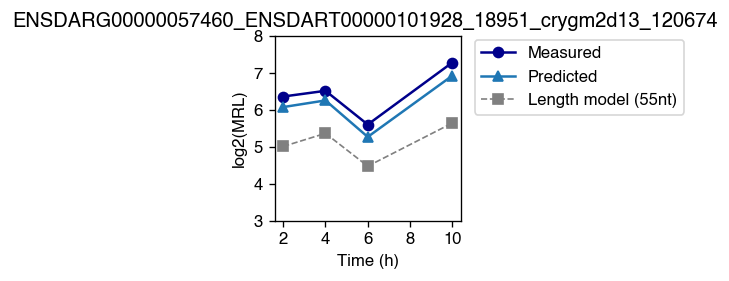

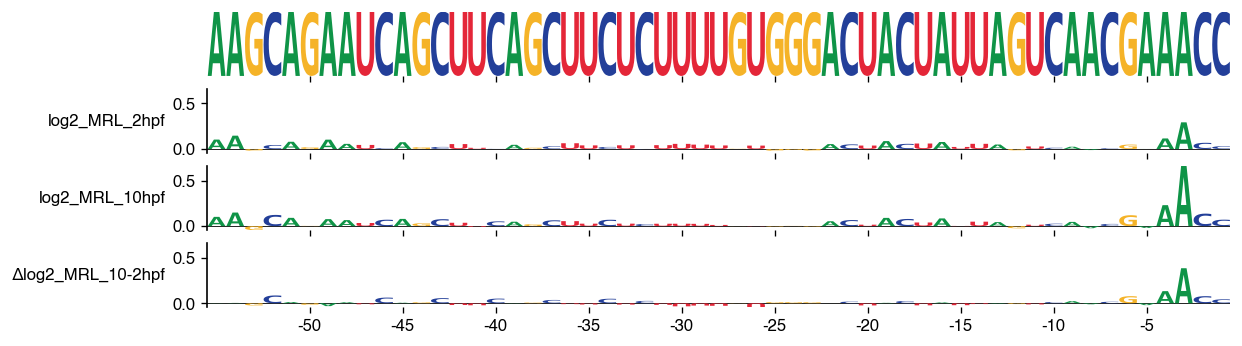

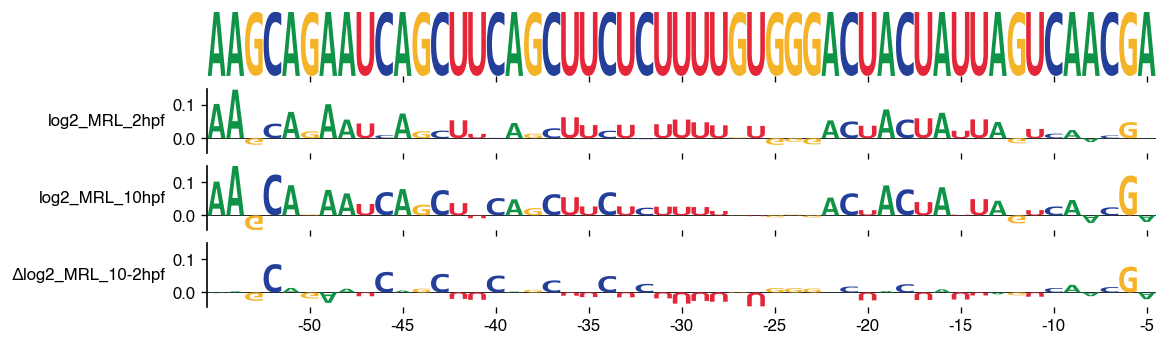

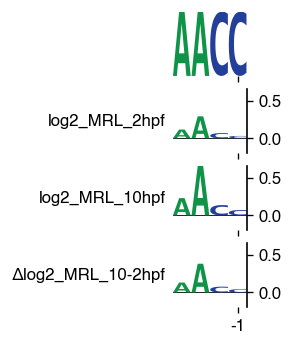

In [12]:
seq_id_to_plot = 'ENSDARG00000057460_ENSDART00000101928_18951_crygm2d13_120674'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(3, 8),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/high_mrl_1_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
);
fig.savefig(f'{example_plot_dir}/high_mrl_1_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.044804587606340644, 0.148984780624236),
);
fig.savefig(f'{example_plot_dir}/high_mrl_1_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.19884542722831625, 0.6612033261868641),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/high_mrl_1_shap_kozak.svg')

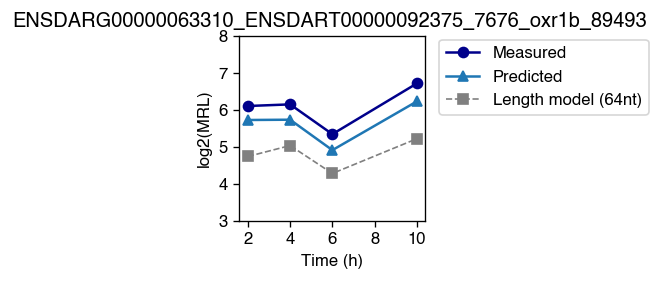

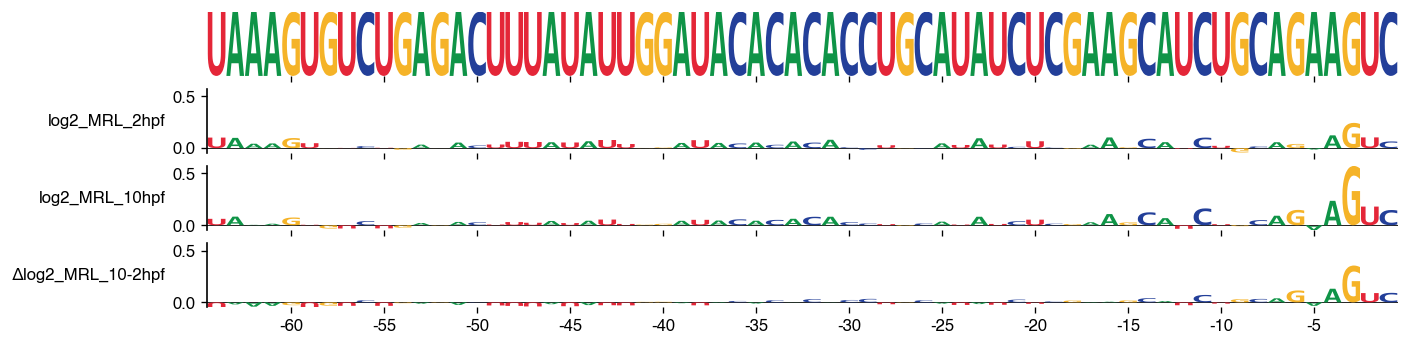

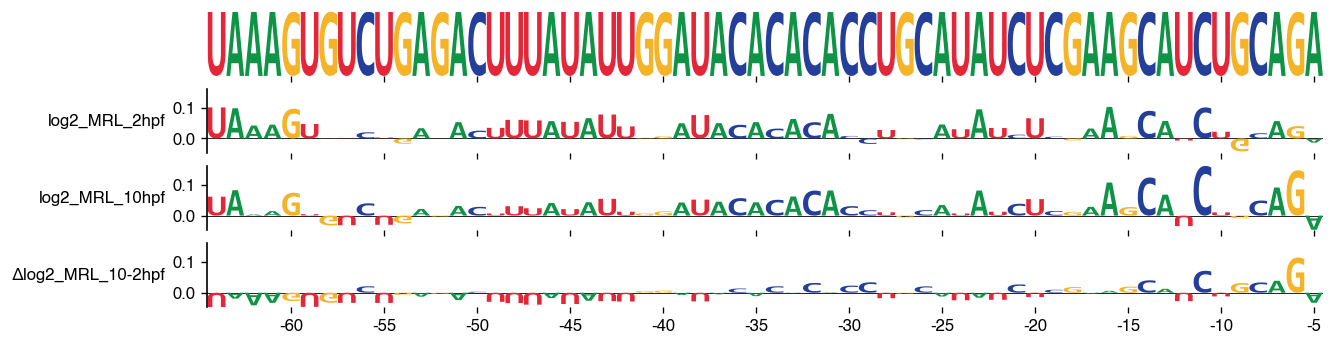

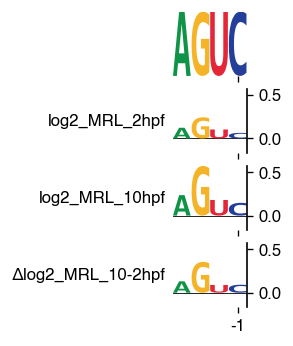

In [13]:
seq_id_to_plot = 'ENSDARG00000063310_ENSDART00000092375_7676_oxr1b_89493'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(3, 8),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/high_mrl_2_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/high_mrl_2_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.04776663173921407, 0.1623650647765862),
);
fig.savefig(f'{example_plot_dir}/high_mrl_2_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.16830724032514927, 0.5720984499588865),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/high_mrl_2_shap_kozak.svg')

### Lower MRL than expected

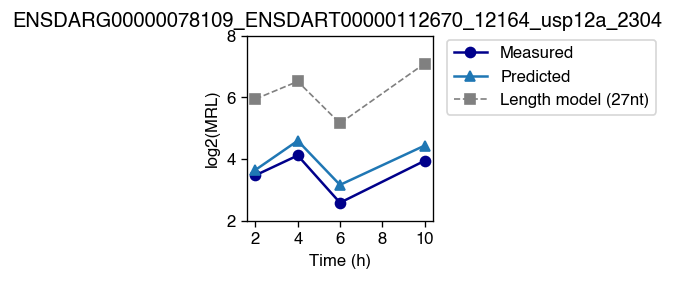

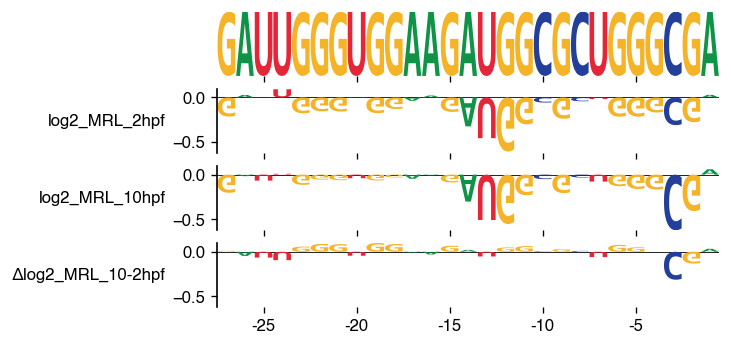

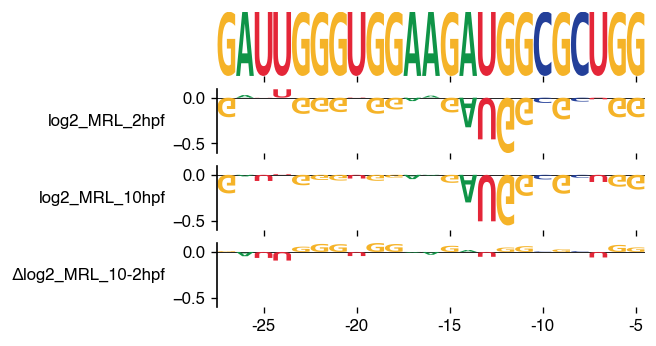

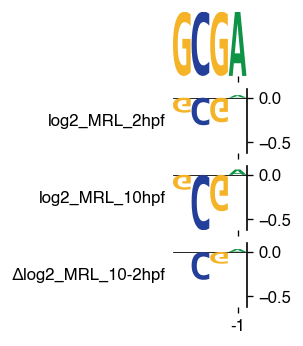

In [14]:
seq_id_to_plot = 'ENSDARG00000078109_ENSDART00000112670_12164_usp12a_2304'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(2, 8),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/low_mrl_1_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/low_mrl_1_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.6056121492385864, 0.09739989117700329),
);
fig.savefig(f'{example_plot_dir}/low_mrl_1_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.6225231277942658, 0.10011966401031035),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/low_mrl_1_shap_kozak.svg')

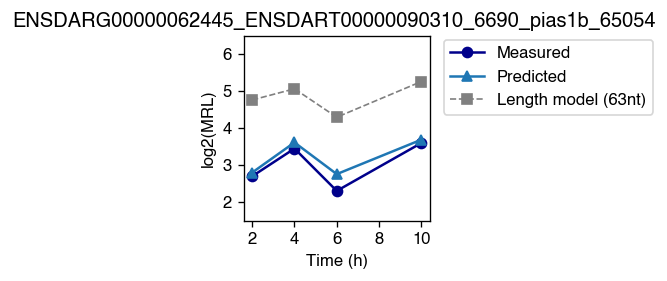

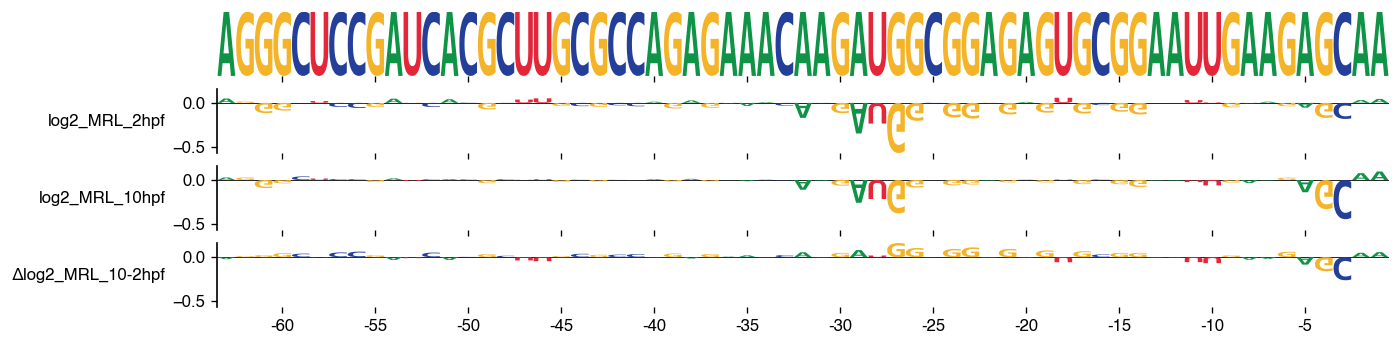

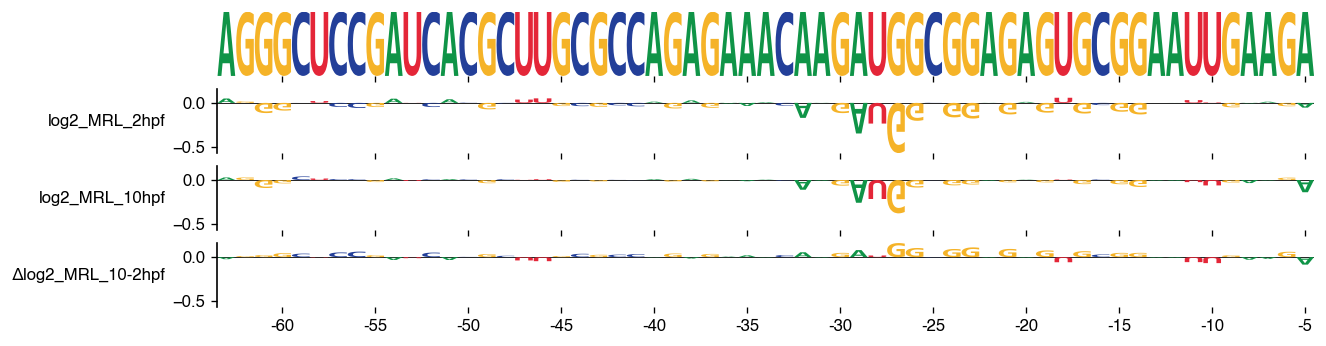

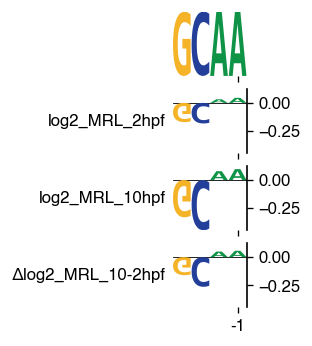

In [15]:
seq_id_to_plot = 'ENSDARG00000062445_ENSDART00000090310_6690_pias1b_65054'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(1.5, 6.5),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/low_mrl_2_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/low_mrl_2_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.5735617786645889, 0.16107062375516634),
);
fig.savefig(f'{example_plot_dir}/low_mrl_2_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.4473071265220642, 0.12561513085266565),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/low_mrl_2_shap_kozak.svg')

### Increasing MRL

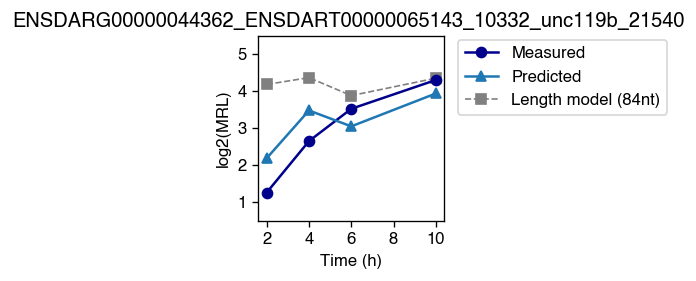

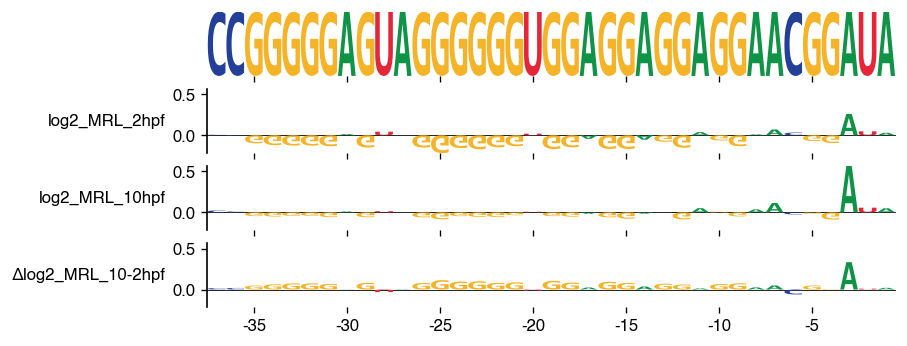

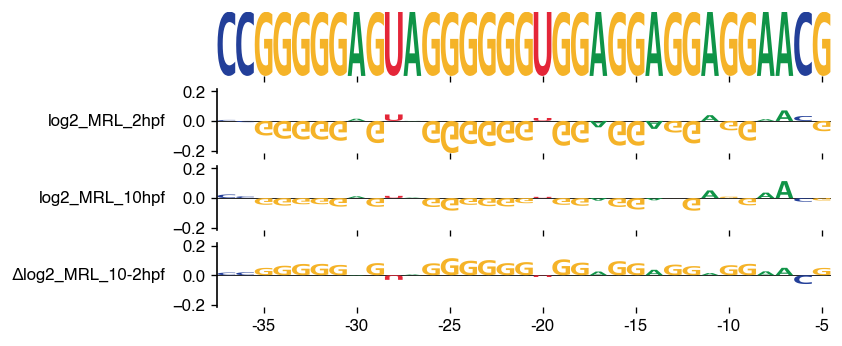

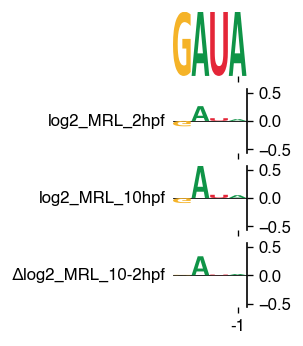

In [16]:
seq_id_to_plot = 'ENSDARG00000044362_ENSDART00000065143_10332_unc119b_21540'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(0.5, 5.5),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_main_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-37, None],
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_main_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-37, -5],
    ylim=(-0.2169291692972183, 0.2169291692972183),
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_main_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.5673536725929295, 0.5673536725929295),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_main_shap_kozak.svg')

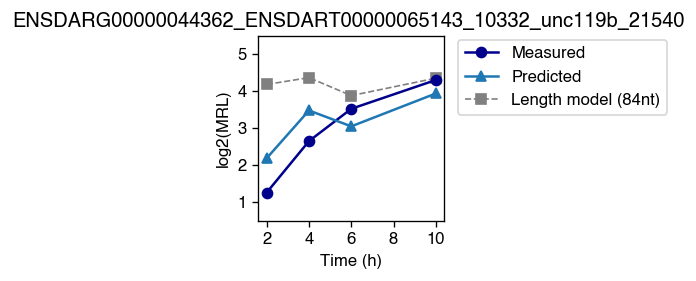

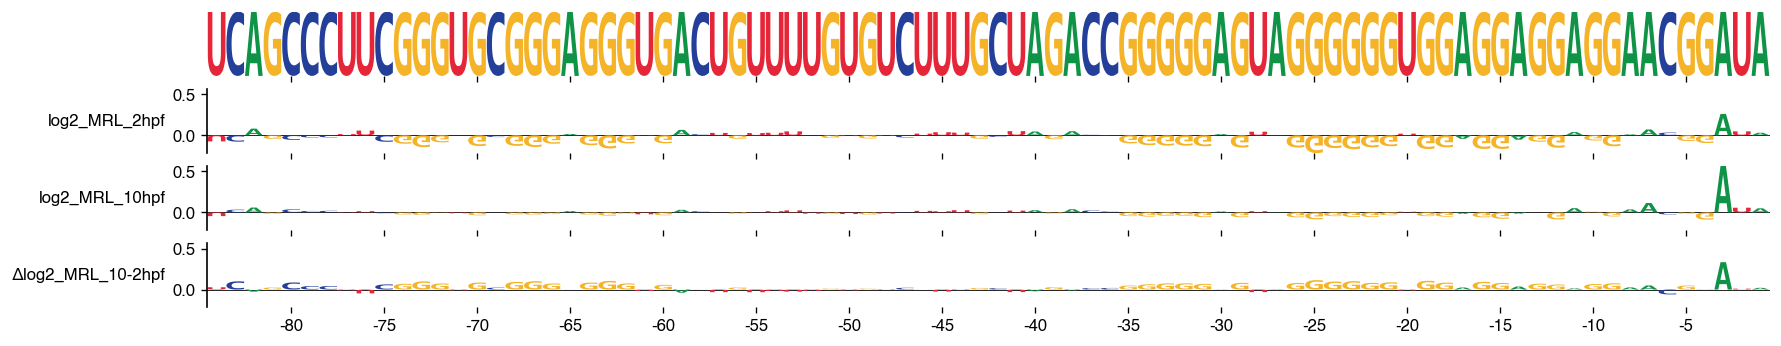

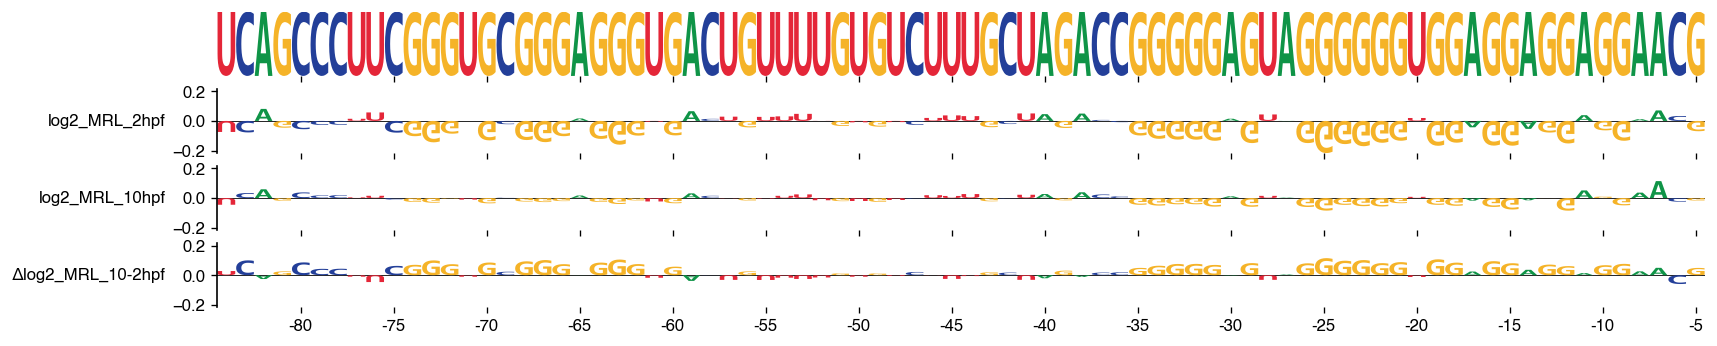

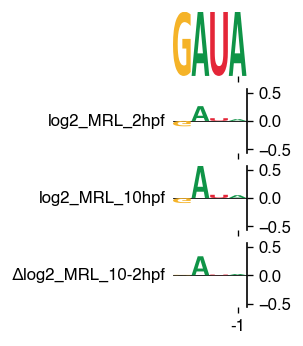

In [17]:
seq_id_to_plot = 'ENSDARG00000044362_ENSDART00000065143_10332_unc119b_21540'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(0.5, 5.5),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_1_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_1_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.2169291692972183, 0.2169291692972183),
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_1_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.5673536725929295, 0.5673536725929295),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_1_shap_kozak.svg')

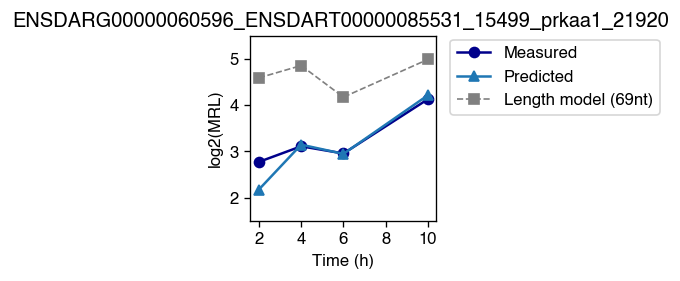

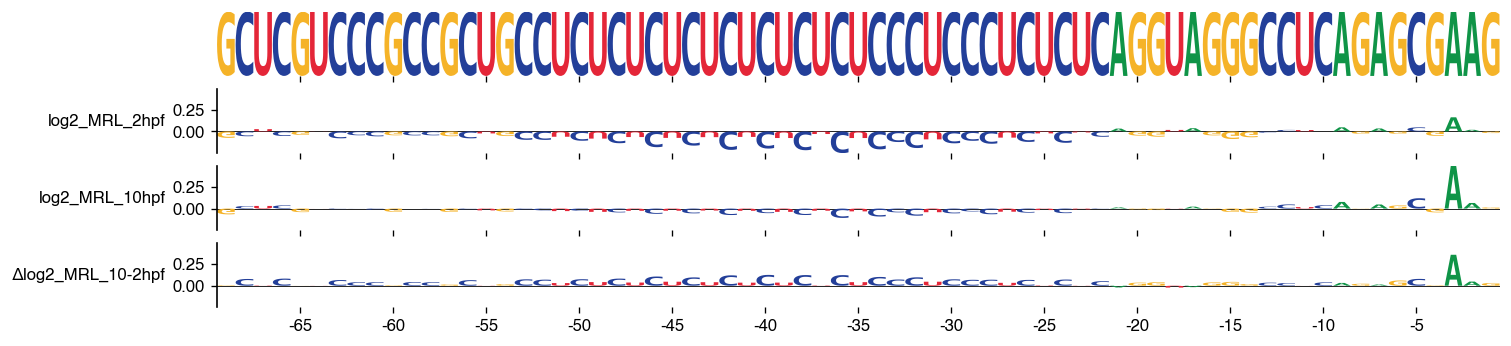

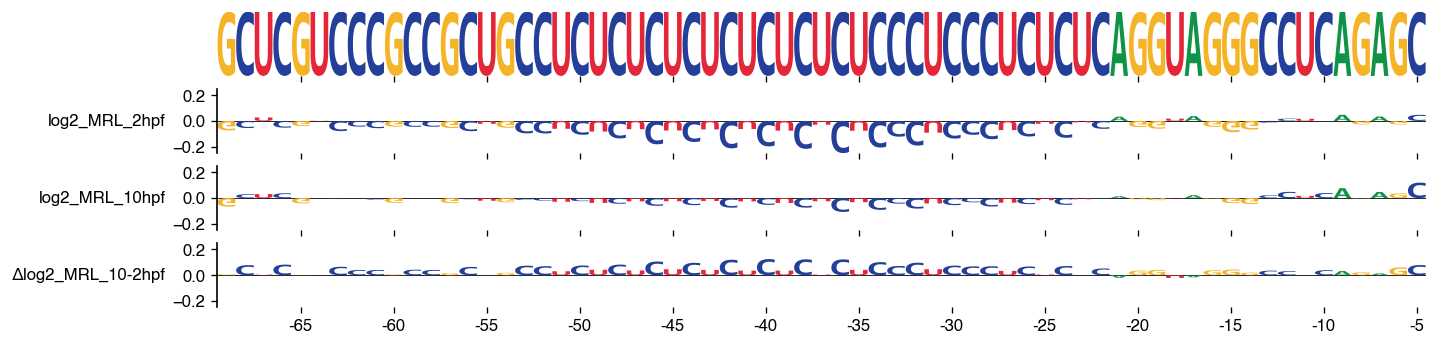

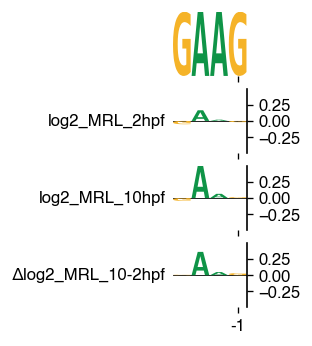

In [18]:
seq_id_to_plot = 'ENSDARG00000060596_ENSDART00000085531_15499_prkaa1_21920'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(1.5, 5.5),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_2_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-37, None],
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_2_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.2499209575355053, 0.2499209575355053),
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_2_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.493510794120271, 0.493510794120271),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_2_shap_kozak.svg')

### Decreasing MRL

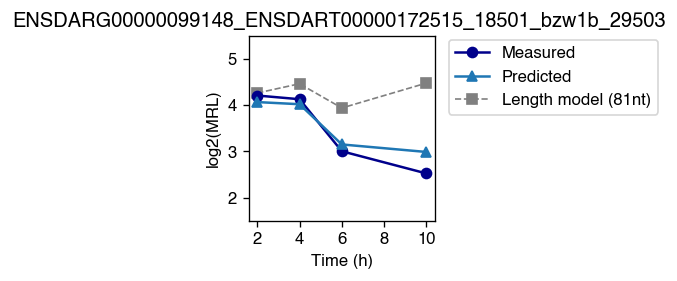

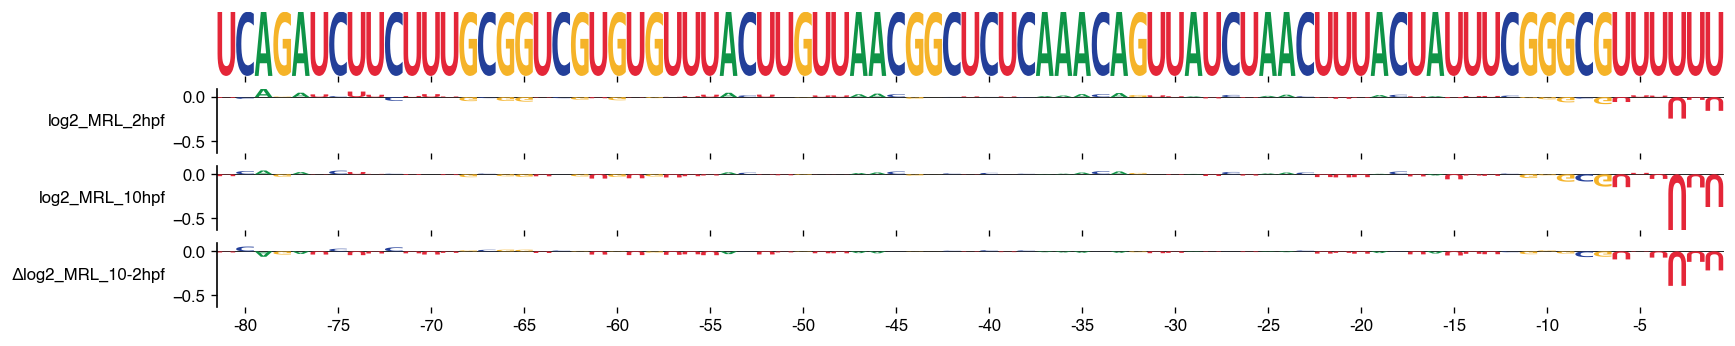

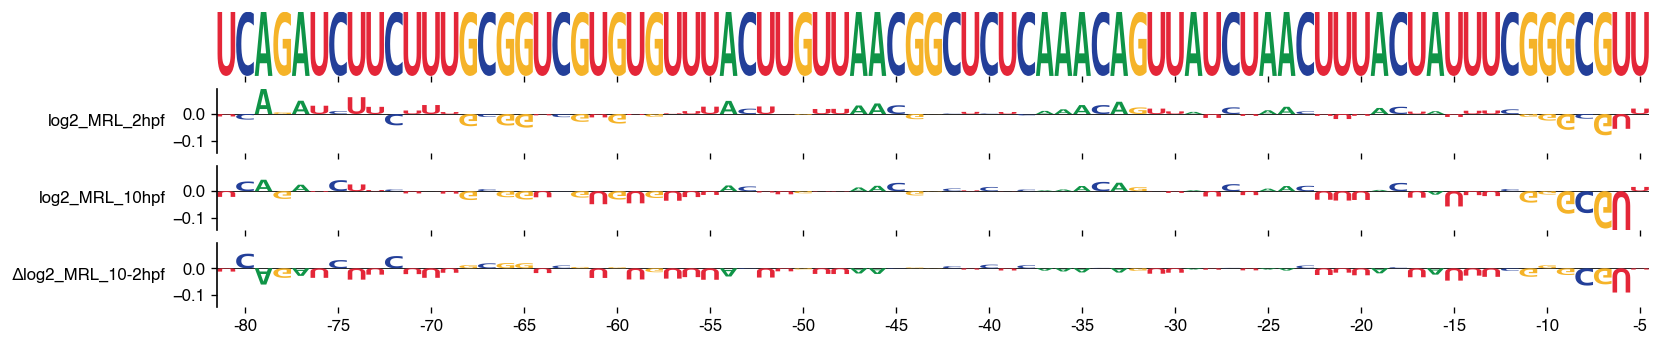

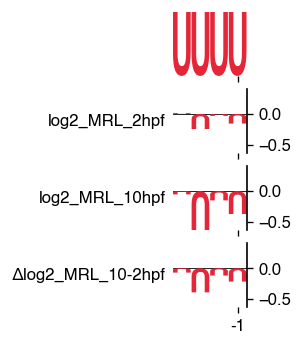

In [19]:
seq_id_to_plot = 'ENSDARG00000099148_ENSDART00000172515_18501_bzw1b_29503'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(1.5, 5.5),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_1_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_1_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.14647005748003722, 0.09461119625327424),
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_1_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-0.6347733950614929, 0.4100269453687172),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_1_shap_kozak.svg')

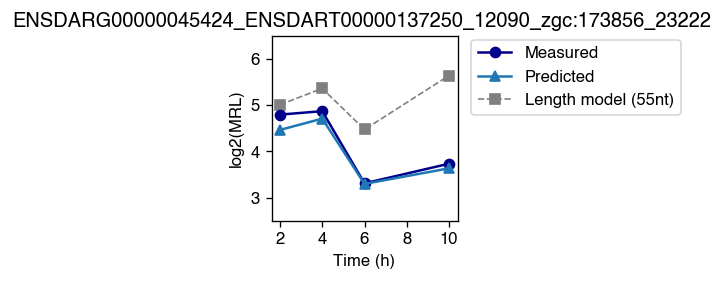

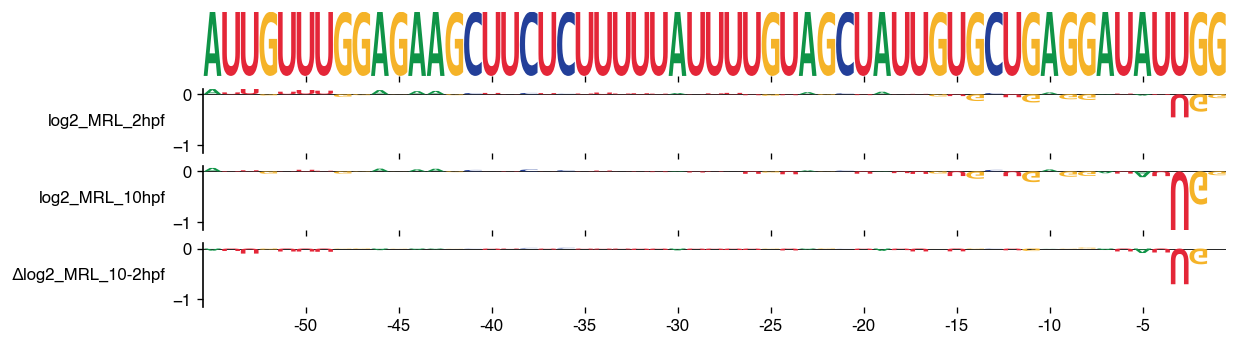

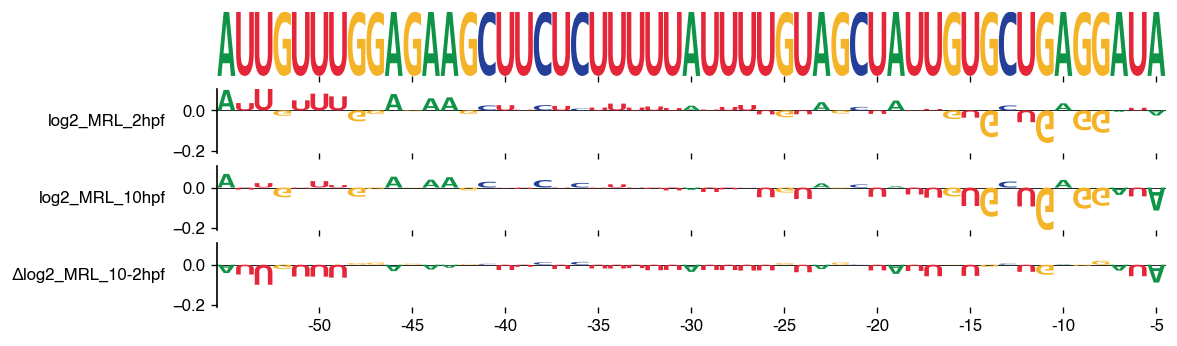

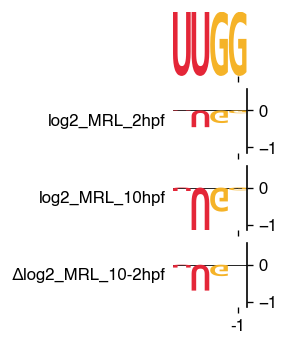

In [20]:
seq_id_to_plot = 'ENSDARG00000045424_ENSDART00000137250_12090_zgc:173856_23222'

fig = plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_total_tpm=False,
    mrl_xticks=[2, 4, 6, 8, 10],
    mrl_ylim=(2.5, 6.5),
    figsize=(2, 2),
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_2_pred_vs_measured.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_2_shap.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[None, -5],
    ylim=(-0.21139916762709618, 0.10723629435173442),
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_2_shap_nonkozak.svg')

fig = plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-4, None],
    ylim=(-1.1537269899249076, 0.5852502092693664),
    ytickpos='right',
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_2_shap_kozak.svg')

# Global trends in contributions

In [21]:
# Get all projected contribution scores in a single array
# Dimensions are n_model_outputs, n_seqs, max_seq_len
seqs_one_hot = seq_utils.one_hot_encode(
    data['insert_seq'].values,
    max_seq_len=data['insert_length'].max(),
    padding='right',
    mask_val=0,
)
all_shap_scores = numpy.zeros((len(model_outputs), len(data), seqs_one_hot.shape[1]))

for row_idx, (seq_id, row) in enumerate(data.iterrows()):
    # Sequence
    seq_one_hot = seqs_one_hot[row_idx]
    # Shap scores
    # Dimensions are (n_outputs, max_seq_len, 4)
    shap_scores = contributions_dict[seq_id]

    for model_output_idx, model_output in enumerate(model_outputs):
        # Project using one-hot sequnce
        # Dimensions are (1, max_seq_len, 4)
        scores_projected = shap_scores[model_output_idx][None,:,:]*seq_one_hot
        # Dimensions are max_seq_len
        scores_projected = numpy.sum(scores_projected[0], axis=-1)
        # Fill zero-padding with numpy.nan
        scores_projected[:-row['insert_length']] = numpy.nan

        # Accumulate
        all_shap_scores[model_output_idx, row_idx, :] = scores_projected


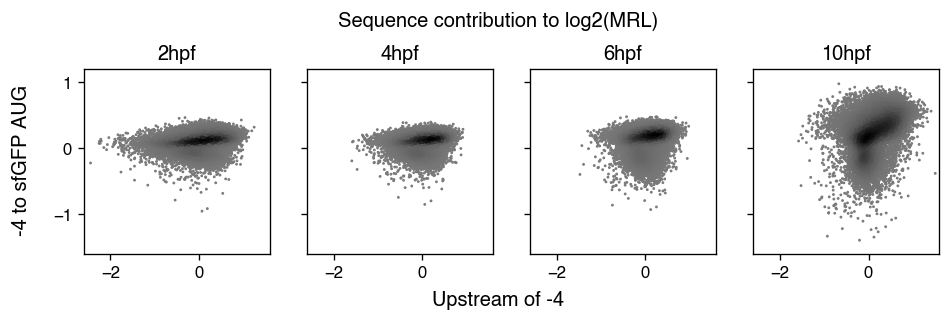

In [22]:
# Proportion of scores before/after specified position
pos_thresh = -4
shap_score_before_thresh = numpy.nansum(all_shap_scores[:, :, :pos_thresh], axis=-1)
shap_score_after_thresh = numpy.nansum(all_shap_scores[:, :, pos_thresh:], axis=-1)

fig, axes = pyplot.subplots(
    1,
    len(log2_mrl_cols),
    figsize=(2.3*len(log2_mrl_cols), 2)
)

# MRL cols
for model_output_idx, model_output in enumerate(log2_mrl_cols):
    ax = axes[model_output_idx]
    custom_plots.plot_scatter_shaded(
        x=shap_score_before_thresh[model_output_idx],
        y=shap_score_after_thresh[model_output_idx],
        ax=ax,
    )
    ax.set_xlim(-2.6, 1.6)
    ax.set_ylim(-1.6, 1.2)
    if model_output_idx>0:
        ax.set_yticklabels([])
    ax.set_title(f'{timepoint_list[model_output_idx]}hpf')

fig.suptitle('Sequence contribution to log2(MRL)', y=1.12)
fig.supxlabel(f"Upstream of {pos_thresh}", y=-0.12)
fig.supylabel(f'{pos_thresh} to sfGFP AUG', x=0.06,)
fig.savefig('sum_scores_by_pos.svg')

# Switching examples

In [23]:
switching_plot_dir = 'switching_plots'
if not os.path.exists(switching_plot_dir):
    os.mkdir(switching_plot_dir)

In [24]:
pre_colors = {
    'measured': 'darkred',
    'predicted': 'tab:red',
    'length': 'lightsalmon',
}
post_colors = {
    'measured': 'darkblue',
    'predicted': 'tab:blue',
    'length': 'lightblue',
}

def plot_switching_timecourse(
        data_df,
        
        pre_seq_id,
        post_seq_id,
        pre_label='Maternal',
        post_label='Zygotic',

        mode='cnn',

        plot_length_pred=True,
        # plot_random=False,

        plot_mrl=True,
        plot_total_tpm=True,

        title=None,

        mrl_ylim=None,
        mrl_xticks=None,

        total_tpm_ylim=None,
        total_tpm_xticks=None,

        figsize=None,
        wspace=.25,
        savefig=None,
    ):

    if (not plot_mrl) and (not plot_total_tpm):
        raise ValueError('one of plot_mrl or plot_total_tpm should be True')
    n_plots = plot_mrl + plot_total_tpm
    
    if figsize is None:
        figsize = (4*n_plots, 4)
    if savefig is not None:
        fig, axes = pyplot.subplots(1, n_plots, squeeze=False, num=1, clear=True)
        fig.set_size_inches(figsize[0], figsize[1])
    else:
        fig, axes = pyplot.subplots(1, n_plots, squeeze=False, figsize=figsize)
    fig.subplots_adjust(wspace=wspace)

    # MRL plot
    if plot_mrl:
        ax = axes[0, 0]

        if mode=='cnn':
            plot_timecourse_ax(
                ax,
                data_df,
                pre_seq_id,
                timepoint_list,
                measured_cols=[f'res_{c}' for c in log2_mrl_cols],
                pred_cols=[f'pred_cnn_ens_{c}' for c in log2_mrl_cols],
                global_label=pre_label,
                color_dict=pre_colors,
            )
            plot_timecourse_ax(
                ax,
                data_df,
                post_seq_id,
                timepoint_list,
                measured_cols=[f'res_{c}' for c in log2_mrl_cols],
                pred_cols=[f'pred_cnn_ens_{c}' for c in log2_mrl_cols],
                global_label=post_label,
                color_dict=post_colors,
            )

        elif mode=='full':
            plot_timecourse_ax(
                ax,
                data_df,
                pre_seq_id,
                timepoint_list,
                measured_cols=log2_mrl_cols,
                pred_cols=[f'pred_full_{c}' for c in log2_mrl_cols],
                pred_len_cols=[f'pred_len_{c}' for c in log2_mrl_cols],
                global_label=pre_label,
                color_dict=pre_colors,
            )
            plot_timecourse_ax(
                ax,
                data_df,
                post_seq_id,
                timepoint_list,
                measured_cols=log2_mrl_cols,
                pred_cols=[f'pred_full_{c}' for c in log2_mrl_cols],
                pred_len_cols=[f'pred_len_{c}' for c in log2_mrl_cols],
                global_label=post_label,
                color_dict=post_colors,
            )

        ax.set_xlabel('Time (h)')
        ax.set_ylabel('log2(MRL)')
        if mrl_ylim is not None:
            if mrl_ylim != 'auto':
                ax.set_ylim(mrl_ylim)
        else:
            if mode=='cnn':
                ax.set_ylim(-4, 4)
            elif mode=='full':
                ax.set_ylim(-1, 9)
        if mrl_xticks is not None:
            ax.set_xticks(mrl_xticks)
        if not plot_total_tpm:
            ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.025))

    if plot_total_tpm:
        if plot_mrl:
            ax = axes[0, 1]
        else:
            ax = axes[0, 0]

        if mode=='cnn':
            plot_timecourse_ax(
                ax,
                data_df,
                pre_seq_id,
                timepoint_list[1:],
                measured_cols=[f'res_{c}' for c in diff_log2_tpm_input_cols],
                pred_cols=[f'pred_cnn_ens_{c}' for c in diff_log2_tpm_input_cols],
                global_label=pre_label,
                color_dict=pre_colors,
            )
            plot_timecourse_ax(
                ax,
                data_df,
                post_seq_id,
                timepoint_list[1:],
                measured_cols=[f'res_{c}' for c in diff_log2_tpm_input_cols],
                pred_cols=[f'pred_cnn_ens_{c}' for c in diff_log2_tpm_input_cols],
                global_label=post_label,
                color_dict=post_colors,
            )
        elif mode=='full':
            plot_timecourse_ax(
                ax,
                data_df,
                pre_seq_id,
                timepoint_list[1:],
                measured_cols=diff_log2_tpm_input_cols,
                pred_cols=[f'pred_full_{c}' for c in diff_log2_tpm_input_cols],
                pred_len_cols=[f'pred_len_{c}' for c in diff_log2_tpm_input_cols],
                global_label=pre_label,
                color_dict=pre_colors,
            )
            plot_timecourse_ax(
                ax,
                data_df,
                post_seq_id,
                timepoint_list[1:],
                measured_cols=diff_log2_tpm_input_cols,
                pred_cols=[f'pred_full_{c}' for c in diff_log2_tpm_input_cols],
                pred_len_cols=[f'pred_len_{c}' for c in diff_log2_tpm_input_cols],
                global_label=post_label,
                color_dict=post_colors,
            )

        ax.set_xlabel('Time (h)')
        ax.set_ylabel('Δlog2(TPM_total)')
        if total_tpm_ylim is not None:
            if total_tpm_ylim != 'auto':
                ax.set_ylim(total_tpm_ylim)
        else:
            if mode=='cnn':
                ax.set_ylim(-2.5, 2)
            elif mode=='full':
                ax.set_ylim(-2.5, 2)
        if total_tpm_xticks is not None:
            ax.set_xticks(total_tpm_xticks)
        ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.025))

    if title is not None:
        fig.suptitle(title)

    if savefig is not None:
        fig.savefig(savefig, dpi=200, bbox_inches='tight')
        # pyplot.close(fig)
        return fig
    else:
        return fig

In [25]:
# info about switching pairs to plot
switching_pairs = [
    {
        'name': 'jpt2',
        'seq_id_pre': 'ENSDARG00000034427_ENSDART00000055780_13012_jpt2_26174',
        'seq_id_post': 'ENSDARG00000034427_ENSDART00000055780_13012_jpt2_4385',
    },
    {
        'name': 'scarb2c',
        'seq_id_pre': 'ENSDARG00000089844_ENSDART00000130648_9696_scarb2c_315',
        'seq_id_post': 'ENSDARG00000089844_ENSDART00000130648_9696_scarb2c_138265',
    },
    {
        'name': 'ube2q2',
        'seq_id_pre': 'ENSDARG00000013990_ENSDART00000124645_12840_ube2q2_22659',
        'seq_id_post': 'ENSDARG00000013990_ENSDART00000124645_12840_ube2q2_2339',
    },
    
    {
        'name': 'zzz3',
        'seq_id_pre': 'ENSDARG00000077581_ENSDART00000134308_8074_zzz3_27788',
        'seq_id_post': 'ENSDARG00000077581_ENSDART00000134308_8074_zzz3_4616',
    },
    {
        'name': 'gpr155a',
        'seq_id_pre': 'ENSDARG00000090804_ENSDART00000147034_18520_gpr155a_28438',
        'seq_id_post': 'ENSDARG00000090804_ENSDART00000147034_18520_gpr155a_13539',
        'label_pre': 'ZGA',
        'label_post': 'PostZGA',
    },
    {
        'name': 'CU694202.1',
        'seq_id_pre': 'ENSDARG00000097014_ENSDART00000156841_18455_CU694202.1_12924',
        'seq_id_post': 'ENSDARG00000097014_ENSDART00000156841_18455_CU694202.1_122913',
        'label_pre': 'ZGA',
        'label_post': 'PostZGA',
    },
    {
        'name': 'cfl1l',
        'seq_id_pre': 'ENSDARG00000012972_ENSDART00000026464_3113_cfl1l_25720',
        'seq_id_post': 'ENSDARG00000012972_ENSDART00000026464_3113_cfl1l_1428',
    },
    {
        'name': 'jam2a',
        'seq_id_pre': 'ENSDARG00000058996_ENSDART00000135944_24_jam2a_338',
        'seq_id_post': 'ENSDARG00000058996_ENSDART00000135944_24_jam2a_1698',
    },
    {
        'name': 'ints1',
        'seq_id_pre': 'ENSDARG00000100419_ENSDART00000163595_13330_ints1_67304',
        'seq_id_post': 'ENSDARG00000100419_ENSDART00000163595_13330_ints1_13639',
        'label_pre': 'ZGA',
        'label_post': 'PostZGA',
    },
]

In [26]:
for switching_pair_idx, switching_pair in enumerate(switching_pairs):
    print(f"Generating plots for gene {switching_pair['name']} ({switching_pair_idx + 1} / {len(switching_pairs)})...")

    if 'label_pre' not in switching_pair:
        switching_pair['label_pre'] = 'Maternal'
    if 'label_post' not in switching_pair:
        switching_pair['label_post'] = 'Zygotic'

    # MRL over time
    mrl_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_mrl.pdf")
    fig = plot_switching_timecourse(
        data,
        pre_seq_id=switching_pair['seq_id_pre'],
        post_seq_id=switching_pair['seq_id_post'],
        pre_label=switching_pair['label_pre'],
        post_label=switching_pair['label_post'],
        mode='full',
        plot_total_tpm=False,
        title=switching_pair['name'],
        mrl_xticks=[2, 4, 6, 8, 10],
        mrl_ylim='auto',
        figsize=(3, 3),
        savefig=mrl_savefig,
    )
    ylim = fig.axes[0].get_ylim()
    fig.axes[0].set_ylim(ylim[0] - 0.5, ylim[1] + 0.5)
    fig.savefig(mrl_savefig, dpi=200, bbox_inches='tight')

    # Contribution scores, pre
    shap_pre_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_shap_{switching_pair['label_pre'].lower()}.pdf")
    fig = plot_contribution_scores(
        data,
        contributions_dict,
        switching_pair['seq_id_pre'],
        outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
        savefig=shap_pre_savefig
    );
    fig.suptitle(switching_pair['name'] + ', ' + switching_pair['label_pre'])
    fig.savefig(shap_pre_savefig, dpi=200, bbox_inches='tight')

    # Contribution scores, post
    shap_post_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_shap_{switching_pair['label_post'].lower()}.pdf")
    fig = plot_contribution_scores(
        data,
        contributions_dict,
        switching_pair['seq_id_post'],
        outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
        savefig=shap_post_savefig
    );
    fig.suptitle(switching_pair['name'] + ', ' + switching_pair['label_post'])
    fig.savefig(shap_post_savefig, dpi=200, bbox_inches='tight')

    # Contribution scores, additional sequence
    shap_delta_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_shap_delta.pdf")
    if data.loc[switching_pair['seq_id_pre'], 'insert_length'] > data.loc[switching_pair['seq_id_post'], 'insert_length']:
        seq_id_to_plot = switching_pair['seq_id_pre']
        end_pos = - data.loc[switching_pair['seq_id_post'], 'insert_length']
        title_suffix = switching_pair['label_pre'] + ' - ' + switching_pair['label_post']
    else:
        seq_id_to_plot = switching_pair['seq_id_post']
        end_pos = - data.loc[switching_pair['seq_id_pre'], 'insert_length']
        title_suffix = switching_pair['label_post'] + ' - ' + switching_pair['label_pre']

    fig = plot_contribution_scores(
        data,
        contributions_dict,
        seq_id_to_plot,
        outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
        pos=[None, end_pos],
        savefig=shap_delta_savefig
    );
    fig.suptitle(switching_pair['name'] + ', ' + title_suffix)
    fig.savefig(shap_delta_savefig, dpi=200, bbox_inches='tight')

pyplot.close(fig)

Generating plots for gene jpt2 (1 / 9)...
Generating plots for gene scarb2c (2 / 9)...
Generating plots for gene ube2q2 (3 / 9)...
Generating plots for gene zzz3 (4 / 9)...
Generating plots for gene gpr155a (5 / 9)...
Generating plots for gene CU694202.1 (6 / 9)...
Generating plots for gene cfl1l (7 / 9)...
Generating plots for gene jam2a (8 / 9)...
Generating plots for gene ints1 (9 / 9)...
